In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from functions import crop_image, build_grid,get_green, normalize_image
import time

In [ ]:
time.wait(5)

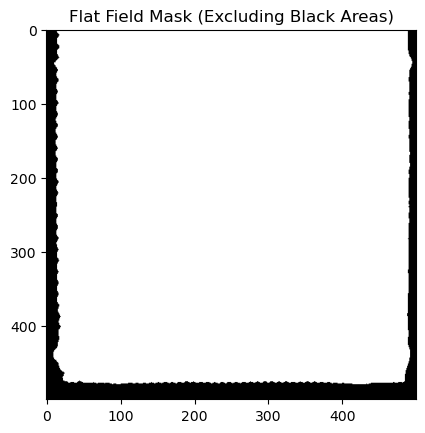

In [ ]:
plt.imshow(mask, cmap='gray')
plt.title("Flat Field Mask (Excluding Black Areas)")
plt.show()

38
[[549, 410], [71, 394], [65, 49], [564, 50]]
5
[[553, 400], [72, 392], [567, 51], [61, 44]]


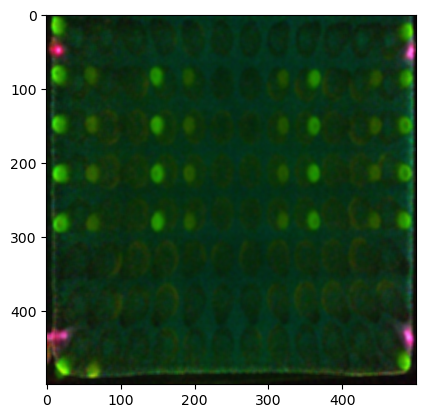

In [ ]:
STATIC_IMAGE_PATH = "../data/images_02_12/MW_G30_05_Extrafilter.jpg"
background = "../data/testbackground.jpg"
image = cv2.imread(STATIC_IMAGE_PATH)
imageInputRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
imageInputRGB = crop_image(imageInputRGB)

background = cv2.imread(background)
backgroundInputRGB = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
backgroundInputRGB = crop_image(backgroundInputRGB)

def normalize_image(image,background):
    
    background = cv2.GaussianBlur(background, (15, 15), 15)
    background = cv2.cvtColor(background, cv2.COLOR_RGB2GRAY)
    raw_image_color_float = image.astype(np.float32)

    flat_field = background.astype(np.float32)

    flat_field += 1e-5
    mask = flat_field > 20
    mean_intensity = np.mean(flat_field[mask])

    flat_field_normalized = np.zeros_like(flat_field)
    flat_field_normalized[mask] = flat_field[mask] / mean_intensity
    flat_field_normalized[~mask] = 1
    corrected_image_color = np.zeros_like(raw_image_color_float)
    for i in range(3):
        corrected_image_color[:, :, i] = raw_image_color_float[:, :, i] / flat_field_normalized

    corrected_image_color = np.clip(corrected_image_color, 0, 255).astype(np.uint8)
    corrected_image_color= cv2.GaussianBlur(corrected_image_color, (5, 5), 5)
    return corrected_image_color

plt.imshow(normalize_image(imageInputRGB,backgroundInputRGB))


(480, 640, 3)
[[551, 407], [72, 393], [565, 54], [65, 50]]
[[551, 407], [72, 393], [565, 54], [65, 50]]
[[553, 400], [72, 393], [567, 51], [61, 44]]


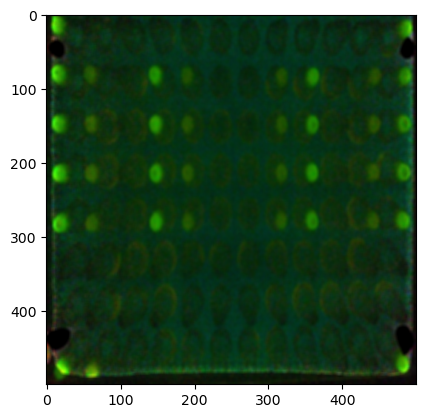

In [3]:
STATIC_IMAGE_PATH = "../data/images_02_12/MW_G30_05_Extrafilter.jpg"
BACKGROUND_IMAGE = "../data/testbackground.jpg"
image = cv2.imread(STATIC_IMAGE_PATH)
imageInputRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(imageInputRGB.shape)
imageInputRGB = crop_image(imageInputRGB)

ROW_LABELS = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
COLUMN_NUMBERS = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
cell_data = {f"{row}{col}": {"state": None,"comment": ""} for row in ROW_LABELS for col in COLUMN_NUMBERS}
cell_data, grid_mask = build_grid(imageInputRGB, cell_data)

imageInput = cv2.imread(STATIC_IMAGE_PATH)
imageInputRGB = cv2.cvtColor(imageInput, cv2.COLOR_BGR2RGB)
imageInputRGB = crop_image(imageInputRGB)
background = cv2.imread(BACKGROUND_IMAGE)
backgroundInputRGB = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
backgroundInputRGB = crop_image(backgroundInputRGB)

imageInputRGB = normalize_image(imageInputRGB,backgroundInputRGB)
final_image, cell_data, grid_mask = get_green(imageInputRGB,cell_data)

#plt.imshow(cell_data["G1"]["cell_image"][:,:,1], cmap='gray')
plt.imshow(imageInputRGB)

In [2]:
def get_green(imageInputRGB, cell_data):
    imageInputRGB = cv2.GaussianBlur(imageInputRGB, (5, 5), 3)
    
    cell_data, grid_mask = build_grid(imageInputRGB,cell_data)
    overlayed_image = cv2.addWeighted(imageInputRGB, 0.8, grid_mask, 0.5, 0)

    for key in cell_data:
        
        green_channel = cell_data[key]["cell_image"][:, :, 1]
        flat_green = green_channel.ravel()
        top_15_indices = np.argsort(flat_green)[-150:]
        mask = np.zeros_like(green_channel, dtype=bool)
        mask.ravel()[top_15_indices] = True
        kernel = np.ones((3, 3), np.uint8)  
        #mask = cv2.erode(mask.astype(np.uint8), kernel, iterations=1)
        #mask = cv2.dilate(mask.astype(np.uint8), kernel, iterations=3)
        cell_data[key]["mask"] = mask
        cell_data[key]["mean_green"] = np.mean(green_channel[mask == 1])
        
        # ---------
        
        cell_coords = cell_data[key]["coordinates"]
        mean_green = cell_data[key]["mean_green"]
        grid_value = cell_data[key]["state"]
        if grid_value == -1:
            text_color = (238, 75, 43)
        elif grid_value == 1:
            text_color = (30,144,255)
        else:
            text_color = (255, 255, 255)

        text = f"{mean_green:.0f}" if mean_green is not None else "None"
        font = cv2.FONT_HERSHEY_SIMPLEX
        text_x = (cell_coords["x_start"] + (cell_coords["x_end"]) - 30) // 2
        text_y = (cell_coords["y_start"] + (cell_coords["y_end"]) + 50) // 2
        cv2.putText(overlayed_image, text, (text_x, text_y), font, 0.4, text_color, 1, cv2.FONT_HERSHEY_SIMPLEX)            
    
    return overlayed_image, cell_data, grid_mask

[[553, 400], [72, 393], [567, 51], [61, 44]]


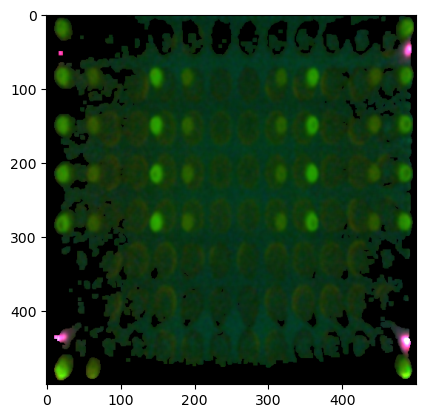

In [ ]:
import cv2
from functions import crop_image, build_grid,get_green, normalize_image
import matplotlib.pyplot as plt
import numpy as np


image = cv2.imread("../data/images_02_12/MW_G30_05_Extrafilter_Alu.jpg")
background = cv2.imread("../data/testbackground.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
image, background = crop_image(image,background)

def normalize_image(image, background, scale_factor=0.5):
    image = cv2.GaussianBlur(image, (5, 5), 5)
    
    image_green = image[:, :, 1]
    mask = image_green.astype(np.float32) > 45
    
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.erode(mask.astype(np.uint8), kernel, iterations=1)
    mask = cv2.dilate(mask.astype(np.uint8), kernel, iterations=2)

    background = cv2.GaussianBlur(background, (15, 15), 15)
    background = cv2.cvtColor(background, cv2.COLOR_RGB2GRAY)
    background_float = background.astype(np.float32)
    background_float += 1e-5
    background_norm = background_float / np.mean(background_float)
    image_float = image.astype(np.float32)
    image_float_corrected = np.zeros_like(image_float)
    for i in range(3):
        image_float_corrected[:, :, i] = image_float[:, :, i] / background_norm
    image_float_corrected = (1 - scale_factor) * image_float + scale_factor * image_float_corrected
    image_float_corrected[mask == 0] = 0
    image_float_corrected = np.clip(image_float_corrected, 0, 255).astype(np.uint8)
    return mask, image_float_corrected

mask,image_float_corrected = normalize_image(image,background,scale_factor=0.3)

plt.imshow(image_float_corrected)
